In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, logging
sys.path.append('./src')
sys.path.append('..')

logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    force=True
)

## High-Dimensional Gaussian (HD) mixtures

In [3]:
from src.catsbench import BenchmarkHDConfig, BenchmarkHD

### Create new benchmark

INFO:catsbench:[Rank 0] Initializing parameters...
INFO:catsbench:[Rank 0] Sampled means (indices):
[[40.  6.]
 [ 5. 10.]
 [ 5. 38.]
 [48. 31.]
 [30. 48.]]
INFO:catsbench:[Rank 0] Initializing prior...
INFO:catsbench:[Rank 0] Initializing validation dataset...


Initializing dataset:   0%|          | 0/40 [00:00<?, ?it/s]

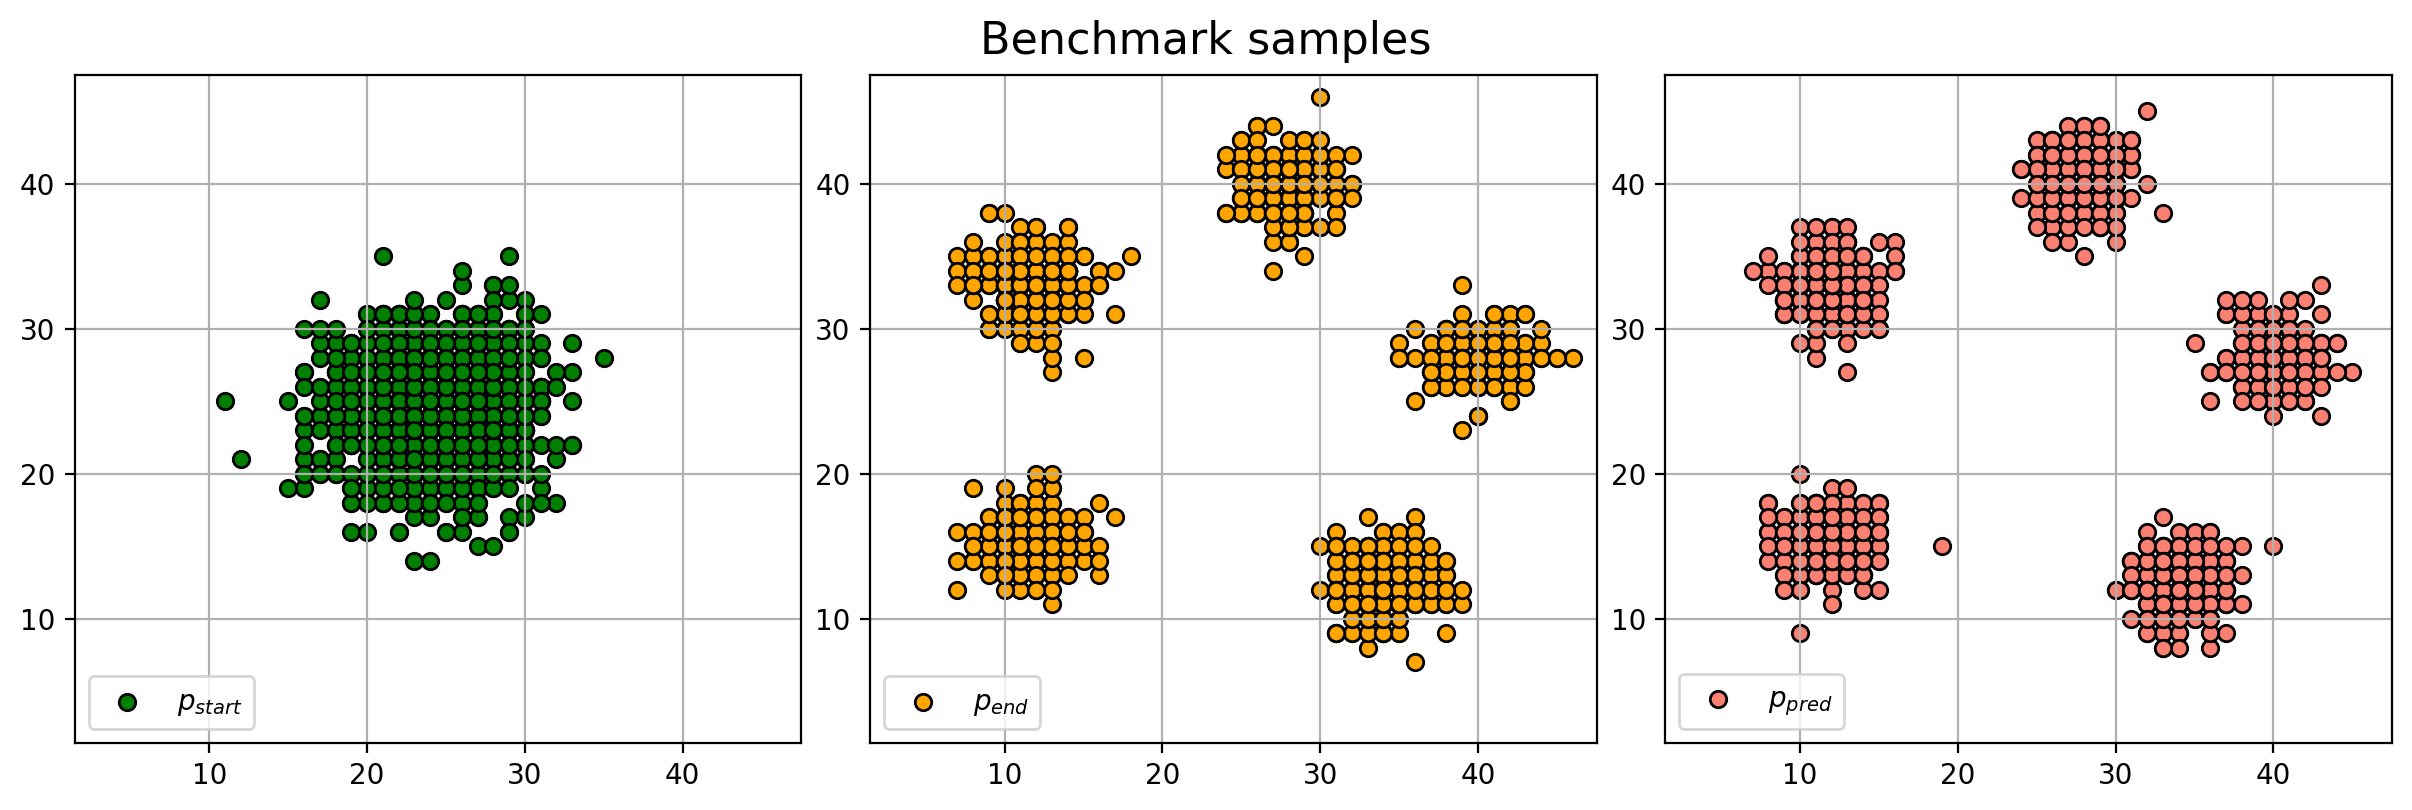

In [15]:
config = BenchmarkHDConfig(
    dim=2,
    input_shape=(2,),
    num_potentials=5,
    num_categories=50,
    radius=5.0,
    alpha=0.02,
    num_timesteps=15,
    num_skip_steps=8,
    prior_type='gaussian',
    benchmark_type='gaussian',
    input_distribution='gaussian',
    num_val_samples=20_000,
    init_batch_size=512,
    reverse=False,
    tau=1.0,
    params_dtype='float32',
)
bench = BenchmarkHD(config)
bench.plot(num_samples=1000, num_trajectories=5, num_translations=3)

### Save benchmark

In [37]:
bench.save_pretrained('./hd_benchmark', subfolder=bench.name)

In [38]:
state_dict = load_file(f'./hd_benchmark/{bench.name}/model.safetensors')
state_dict.keys()

dict_keys(['input_dataset', 'target_dataset', 'log_alpha', 'log_cp_cores'])

### Load benchmark

It is preferable to load the benchmark class with the parameter `init_benchmark=False`. This skips the sampling of the validation dataset and loads it directly from the checkpoint, which is especially recommended for image and text benchmarks.

INFO:catsbench:[Rank 0] Skipping parameters initialization!
INFO:catsbench:[Rank 0] Initializing prior...
INFO:catsbench:[Rank 0] Skipping dataset initialization!
Loading weights from local directory


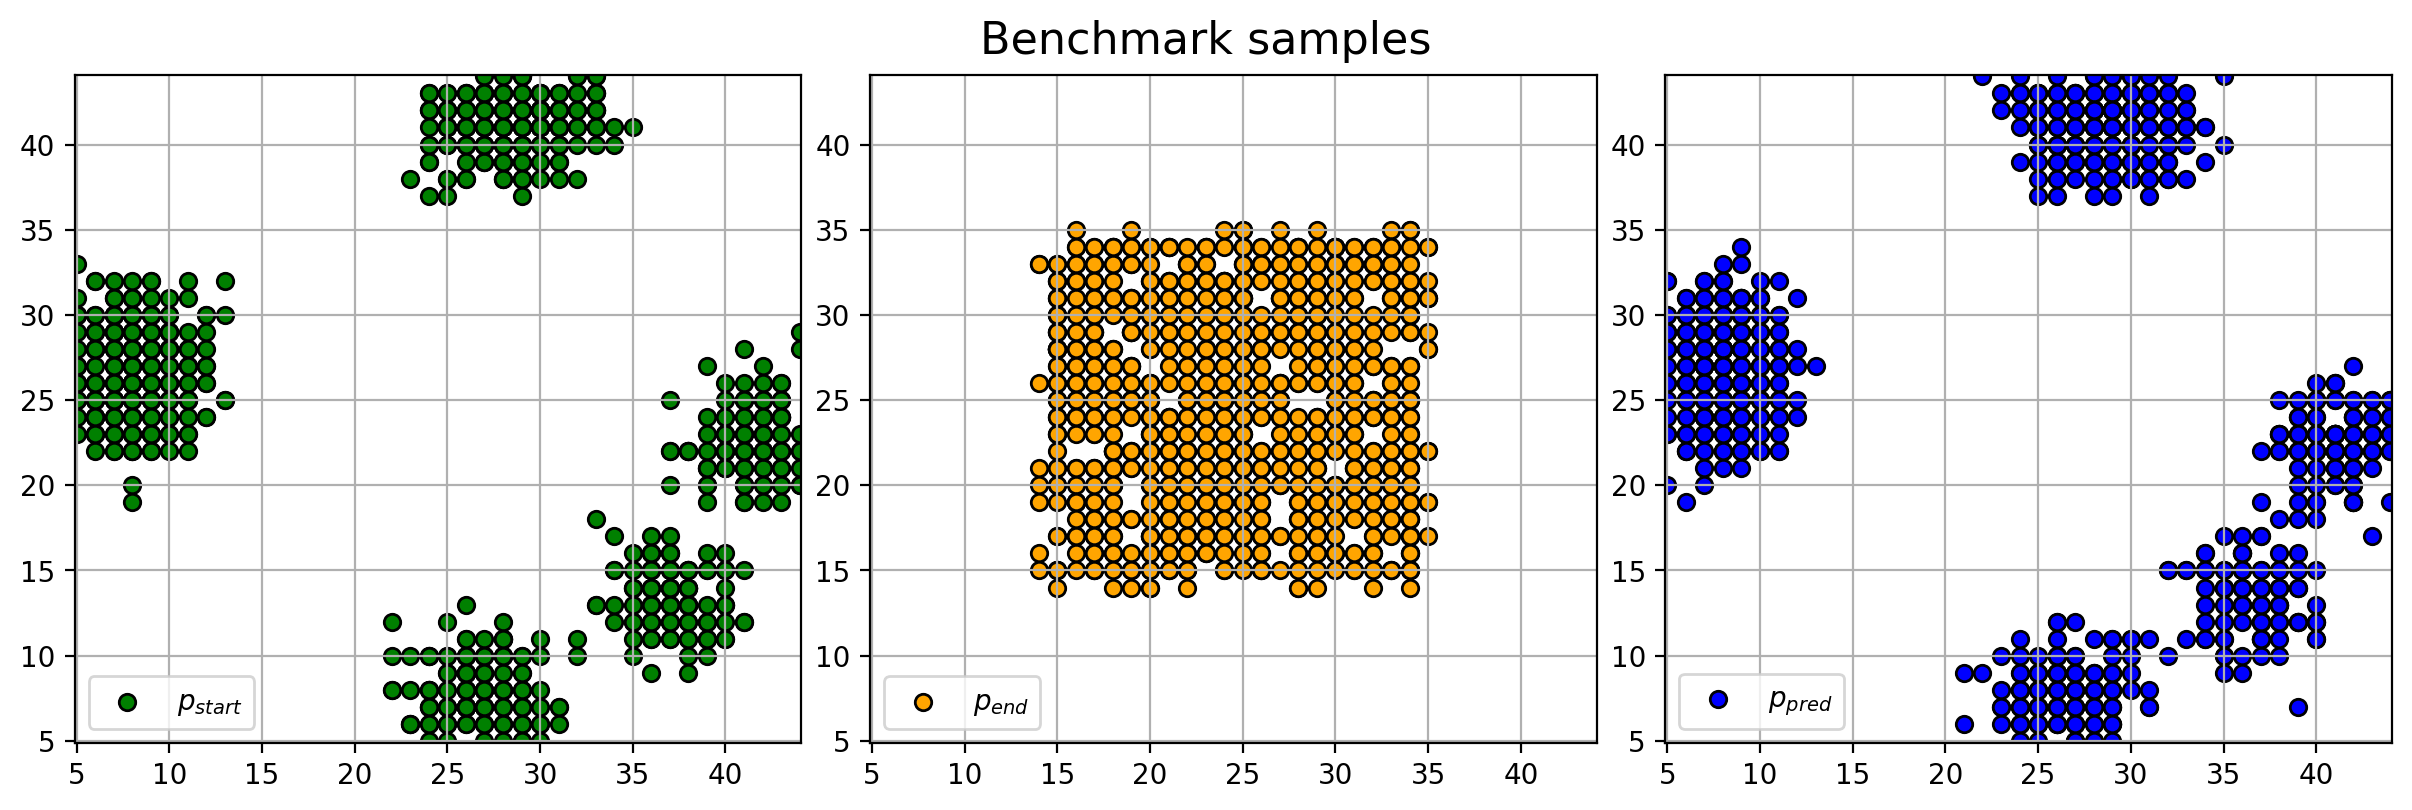

In [39]:
bench_copy = BenchmarkHD.from_pretrained('./hd_benchmark', bench.name, init_benchmark=False)
bench_copy.plot(num_samples=1000, num_trajectories=5, num_translations=3)

In [40]:
assert torch.allclose(bench.log_alpha, bench_copy.log_alpha), \
    'Values of log_alpha do not match after loading from checkpoint!'
assert torch.allclose(bench.log_cp_cores, bench_copy.log_cp_cores), \
    'Values of log_cp_cores do not match after loading from checkpoint!'
assert torch.allclose(bench.input_dataset, bench_copy.input_dataset), \
    'Values of input_dataset do not match after loading from checkpoint!'
assert torch.allclose(bench.target_dataset, bench_copy.target_dataset), \
    'Values of target_dataset do not match after loading from checkpoint!'

### Upload benchmark to HuggigFace

In [41]:
bench.push_to_hub(
    repo_id='gregkseno/catsbench',
    subfolder=bench.name,
    commit_message=f'Add {bench.name}',
    token=os.getenv('HF_HUB_TOKEN')
)

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/gregkseno/catsbench/commit/9dedebe0776590fb6e986ee8b900eba378b963b5', commit_message='Add hd_d2_s50_gaussian_a0.02_gaussian', commit_description='', oid='9dedebe0776590fb6e986ee8b900eba378b963b5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gregkseno/catsbench', endpoint='https://huggingface.co', repo_type='model', repo_id='gregkseno/catsbench'), pr_revision=None, pr_num=None)

In [42]:
bench_copy = BenchmarkHD.from_pretrained(
    'gregkseno/catsbench', 'hd_d2_s50_gaussian_a0.02_gaussian', init_benchmark=False
)

config.json:   0%|          | 0.00/365 [00:00<?, ?B/s]

INFO:catsbench:[Rank 0] Skipping parameters initialization!
INFO:catsbench:[Rank 0] Initializing prior...
INFO:catsbench:[Rank 0] Skipping dataset initialization!


hd_d2_s50_gaussian_a0.02_gaussian/model(…):   0%|          | 0.00/642k [00:00<?, ?B/s]

In [44]:
bench_copy.plot(num_samples=1000, num_trajectories=5, num_translations=3)

## Images

In [5]:
from src.catsbench import BenchmarkImageConfig, BenchmarkImage

### Create new benchmark

In [6]:
config = BenchmarkImageConfig(
    dim=3072,
    input_shape=(3, 32, 32),
    num_potentials=10,
    num_categories=256,
    alpha=0.02,
    num_timesteps=15,
    num_skip_steps=8,
    prior_type='gaussian',
    benchmark_type='gaussian',
    num_val_samples=60,
    init_batch_size=4,
    reverse=True,
    tau=1.0,
    generator_kwargs={
        'z_dim': 512, 'c_dim': 0, 'w_dim': 512,
        'img_resolution': 32,
        'img_channels': 3,
    },
    params_dtype='float32',
)
bench = BenchmarkImage(
    config, 
    generator_path='./checkpoints/cmnist_stylegan2.pkl',
    device='cuda',
)

TypeError: BenchmarkImageConfig.__init__() missing 1 required positional argument: 'radius'

In [24]:
bench.plot(num_samples=16, num_trajectories=5, num_translations=3)

### Save benchmark

In [26]:
bench.save_pretrained('./hd_benchmark', subfolder=bench.name)

In [27]:
state_dict = load_file(f'./hd_benchmark/{bench.name}/model.safetensors')
state_dict.keys()

dict_keys(['input_dataset', 'target_dataset', 'generator.mapping.fc0.bias', 'generator.mapping.fc0.weight', 'generator.mapping.fc1.bias', 'generator.mapping.fc1.weight', 'generator.mapping.fc2.bias', 'generator.mapping.fc2.weight', 'generator.mapping.fc3.bias', 'generator.mapping.fc3.weight', 'generator.mapping.fc4.bias', 'generator.mapping.fc4.weight', 'generator.mapping.fc5.bias', 'generator.mapping.fc5.weight', 'generator.mapping.fc6.bias', 'generator.mapping.fc6.weight', 'generator.mapping.fc7.bias', 'generator.mapping.fc7.weight', 'generator.mapping.w_avg', 'generator.synthesis.b16.conv0.affine.bias', 'generator.synthesis.b16.conv0.affine.weight', 'generator.synthesis.b16.conv0.bias', 'generator.synthesis.b16.conv0.noise_const', 'generator.synthesis.b16.conv0.noise_strength', 'generator.synthesis.b16.conv0.resample_filter', 'generator.synthesis.b16.conv0.weight', 'generator.synthesis.b16.conv1.affine.bias', 'generator.synthesis.b16.conv1.affine.weight', 'generator.synthesis.b16.co

### Load benchmark

In [46]:
bench_copy = BenchmarkImage.from_pretrained('./hd_benchmark', bench.name, init_benchmark=False, device='cpu')
bench.plot(num_samples=16, num_trajectories=5, num_translations=3)

HFValidationError: Repo id must use alphanumeric chars, '-', '_' or '.'. The name cannot start or end with '-' or '.' and the maximum length is 96: './hd_benchmark'.

In [29]:
bench = bench.cpu()
assert torch.allclose(bench.log_alpha, bench_copy.log_alpha), \
    'Values of log_alpha do not match after loading from checkpoint!'
assert torch.allclose(bench.log_cp_cores, bench_copy.log_cp_cores), \
    'Values of log_cp_cores do not match after loading from checkpoint!'
assert torch.allclose(bench.input_dataset, bench_copy.input_dataset), \
    'Values of input_dataset do not match after loading from checkpoint!'
assert torch.allclose(bench.target_dataset, bench_copy.target_dataset), \
    'Values of target_dataset do not match after loading from checkpoint!'

### Upload benchmark to HuggigFace

In [37]:
bench_copy.push_to_hub(
    repo_id='gregkseno/catsbench',
    subfolder=bench_copy.name,
    commit_message=f'Fix params {bench_copy.name}',
    token=os.getenv('HF_HUB_TOKEN')
)

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/gregkseno/catsbench/commit/e09e655e21f69bd7e69680f0b38d8e25d0e6d25b', commit_message='Fix params image_d3072_s256_prior_gaussian_a0.02', commit_description='', oid='e09e655e21f69bd7e69680f0b38d8e25d0e6d25b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gregkseno/catsbench', endpoint='https://huggingface.co', repo_type='model', repo_id='gregkseno/catsbench'), pr_revision=None, pr_num=None)

In [11]:
bench_copy = BenchmarkImage.from_pretrained(
    'gregkseno/catsbench', 'image_d3072_s256_prior_gaussian_a0.01',
    init_benchmark=False, strict=False, revision='reshaped_log_cp_cores'
)

INFO:src.catsbench.benchmarks.image:[Rank 0] Skipping StyleGAN2 generator initialization!
INFO:catsbench:[Rank 0] Skipping parameters initialization!
INFO:catsbench:[Rank 0] Initializing prior...


INFO:catsbench:[Rank 0] Skipping dataset initialization!


model.safetensors:   0%|          | 0.00/3.07G [00:00<?, ?B/s]

In [ ]:
bench_copy.input_dataset, bench_copy.target_dataset = bench_copy._init_dataset(60_000, 128)

Initializing dataset:   0%|          | 0/469 [00:00<?, ?it/s]

In [12]:
import matplotlib.pyplot as plt
import torchvision

inp, targ = bench_copy.sample_input_target(16)
inp = torchvision.utils.make_grid(inp, nrow=4).cpu()
targ = torchvision.utils.make_grid(targ, nrow=4).cpu()
fig, axs = plt.subplots(1, 2)
axs[0].imshow(inp.numpy().transpose(1, 2, 0))
axs[1].imshow(targ.numpy().transpose(1, 2, 0))
plt.show()

In [14]:
from catsbench.stylegan2 import legacy, dnnlib
from catsbench.stylegan2.training.networks import Generator

In [15]:
generator_path = './checkpoints/cmnist_stylegan2.pkl'
with dnnlib.util.open_url(generator_path) as f:
    generator: Generator = legacy.load_network_pkl(f)['G_ema'].cuda()

In [14]:
bench_copy.plot(num_samples=16, num_trajectories=5, num_translations=3)

In [16]:
noise = torch.randn((32, 512), device='cuda')
images = generator(noise, None)
images = (images * 0.5 + 0.5).clamp(0, 1)
save_image(images, './sample.jpg')

NameError: name 'save_image' is not defined